# Prepare Data


In [1]:
import os

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

2024-05-27 10:42:47.777581: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 10:42:48.039482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 10:42:48.604044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
_DATA_DIR = "ships_gray/"
_CLASSES = {
    "coastguard_scaled": 0,
    "containership_scaled": 1,
    "corvette_scaled": 2,
    "cruiser_scaled": 3,
    "cv_scaled": 4,
    "destroyer_scaled": 5,
    "methanier_scaled": 6,
    "smallfish_scaled": 7,
    "submarine_scaled": 8,
    "tug_scaled": 9,
}
_CLASS_NAMES = list(_CLASSES.keys())
_N_CLASSES = len(_CLASS_NAMES)

In [3]:
_SEED = 42
_VALIDATION_SIZE = 0.15
_BATCH_SIZE = 32
_IMG_HEIGHT = 128
_IMG_WIDTH = 192
_MAX_LAYERS = 30

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# os.environ["PYTHONHASHSEED"] = str(_SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
import random

random.seed(_SEED)
tf.random.set_seed(_SEED)
np.random.seed(_SEED)

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=_VALIDATION_SIZE,
    rescale=1.0 / 255,
)

train_gen = datagen.flow_from_directory(
    _DATA_DIR,
    target_size=(_IMG_HEIGHT, _IMG_WIDTH),
    color_mode="grayscale",
    classes=_CLASSES,
    class_mode="categorical",
    batch_size=_BATCH_SIZE,
    keep_aspect_ratio=True,
    subset="training",
    shuffle=True,
    seed=_SEED,
)

val_gen = datagen.flow_from_directory(
    _DATA_DIR,
    target_size=(_IMG_HEIGHT, _IMG_WIDTH),
    color_mode="grayscale",
    classes=_CLASSES,
    class_mode="categorical",
    batch_size=_BATCH_SIZE,
    keep_aspect_ratio=True,
    subset="validation",
    shuffle=True,
    seed=_SEED,
)

Found 35878 images belonging to 10 classes.
Found 6326 images belonging to 10 classes.


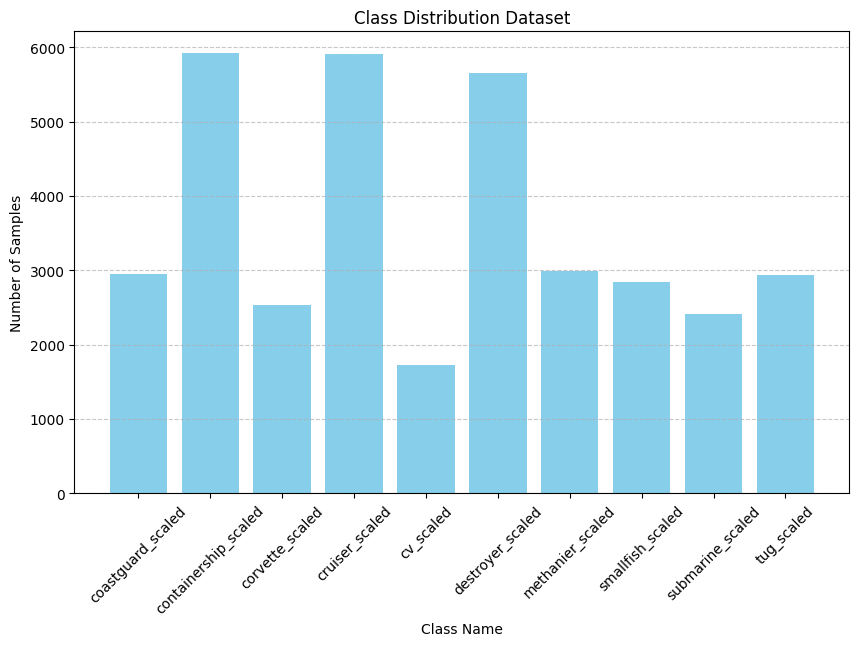

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(_CLASS_NAMES, np.bincount(train_gen.classes), color="skyblue")
plt.title("Class Distribution Dataset")
plt.xlabel("Class Name")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

There is clearly a class imbalance. In order to fix this, we'll compute class weight in order to influence the training process.


In [6]:
_CLASS_WEIGHT = compute_class_weight(
    "balanced", classes=np.arange(_N_CLASSES), y=train_gen.classes
)
_CLASS_WEIGHT = {ii: weight for ii, weight in enumerate(_CLASS_WEIGHT)}
_CLASS_WEIGHT

{0: 1.21414551607445,
 1: 0.6061496874472039,
 2: 1.4192246835443039,
 3: 0.6075867908552075,
 4: 2.0798840579710145,
 5: 0.6350088495575221,
 6: 1.1971304637971305,
 7: 1.260203723217422,
 8: 1.4825619834710744,
 9: 1.223669849931787}

# Model


We'll use a customized (simpler) version of the VGG16 architecture.

![VGG16](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FMengyun-Liu-4%2Fpublication%2F327060416%2Ffigure%2Ffig1%2FAS%3A660427612622849%401534469621448%2FArchitecture-of-VGG16.png&f=1&nofb=1&ipt=7e60483b05ab9e7d4b695edc001a1440825339fbdf344b1ce334a8f08dd1c14f&ipo=images)


### Define Timeout Callback


The submission session has a timeout of 12h of execution.


In [7]:
import time

_TIMEOUT_H = 24
_TIMEOUT_S = _TIMEOUT_H * 60 * 60
_BEST_MODEL_PATH = "best_model.keras"


class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, timeout_s):
        super(TimeoutCallback, self).__init__()
        self.timeout_s = timeout_s
        self.start_time = None

    @property
    def seconds_since_begin(self):
        return time.time() - self.start_time

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            hours_spent = round(self.seconds_since_begin / 3600, 2)
            print(f"\nTraining stopped after {hours_spent} hours")
            print("\nRestoring model to the best weights from training")
            self.model.load_weights(_BEST_MODEL_PATH)

    def on_epoch_end(self, epoch, logs=None):
        if self.seconds_since_begin > self.timeout_s:
            self.model.stop_training = True
            print("\nTraining stopped due to timeout")

### Some Code Factorisation


The purpose of this is to use a batch normalization layer for each convolution and dense layers.


In [8]:
def Dense_BN(units):
    layer = tf.keras.Sequential()
    layer.add(
        tf.keras.layers.Dense(units, kernel_initializer="he_uniform", activation="relu")
    )
    layer.add(tf.keras.layers.BatchNormalization())
    return layer


def Conv2D_BN(filters):
    layer = tf.keras.Sequential()
    layer.add(
        tf.keras.layers.Conv2D(
            filters,
            kernel_size=(3, 3),
            padding="same",
            kernel_initializer="he_uniform",
            activation="relu",
        )
    )
    layer.add(tf.keras.layers.BatchNormalization())
    return layer

Now, because there are sequentials used for the code factorisation mentioned above, simply using `len(model.layers)` is no longer enough.


In [9]:
def count_layers(model):
    return sum(
        [len(layer.layers) if hasattr(layer, "layers") else 1 for layer in model.layers]
    )

### Define the Model Architecture


In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(_IMG_HEIGHT, _IMG_WIDTH, 1)))

model.add(Conv2D_BN(128))
model.add(Conv2D_BN(128))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.SpatialDropout2D(0.2, seed=_SEED))

model.add(Conv2D_BN(256))
model.add(Conv2D_BN(256))
model.add(Conv2D_BN(256))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.SpatialDropout2D(0.3, seed=_SEED))

model.add(Conv2D_BN(512))
model.add(Conv2D_BN(512))
model.add(Conv2D_BN(512))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.SpatialDropout2D(0.4, seed=_SEED))

model.add(tf.keras.layers.Flatten())

model.add(Dense_BN(1024))
model.add(tf.keras.layers.Dropout(0.5, seed=_SEED))
model.add(Dense_BN(1024))
model.add(tf.keras.layers.Dropout(0.6, seed=_SEED))

model.add(tf.keras.layers.Dense(_N_CLASSES, activation="softmax"))

2024-05-27 10:42:50.187648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 10:42:50.292938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 10:42:50.293039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

We have to make sure there are under 30 layers.


In [11]:
layers_amount = count_layers(model)
print(f"The model truly has {layers_amount} layers")
assert layers_amount <= _MAX_LAYERS

The model truly has 30 layers


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 192, 128)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 192, 128)  │       148,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 64, 96, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 64, 96, 256)    │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 64, 96, 256)    │       591,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 64, 96, 256)    │       591,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 32, 48, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 32, 48, 512)    │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32, 48, 512)    │     2,361,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 32, 48, 512)    │     2,361,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 16, 24, 512)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 1024)           │   201,331,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 1024)           │     1,053,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,929,866 (800.82 MB)

 Trainable params: 209,920,650 (800.78 MB)

 Non-trainable params: 9,216 (36.00 KB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=0.01,
        weight_decay=0.0005,
        nesterov=True,
        momentum=0.9,
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

### Train the Model


An important trick we use here is `verbose=2`, which reduces notebook output size and therefore allows more time for training within the allotted 12 hours by avoiding the time spent writing bytes for the final version of the notebook.

In [14]:
history = model.fit(
    train_gen,
    class_weight=_CLASS_WEIGHT,
    validation_data=val_gen,
    epochs=400,
    verbose=2,  # One line per epoch
    callbacks=[
        TimeoutCallback(timeout_s=_TIMEOUT_S),
        tf.keras.callbacks.ModelCheckpoint(
            _BEST_MODEL_PATH,
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=20,
            restore_best_weights=True,
        ),
    ],
)

Epoch 1/400


/home/ucin/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716799373.632248    7710 service.cc:145] XLA service 0x799870008140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716799373.632269    7710 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-27 10:42:53.694160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 10:42:53.847643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-05-27 10:43:09


Epoch 1: val_accuracy improved from -inf to 0.36658, saving model to best_model.keras
1122/1122 - 351s - 313ms/step - accuracy: 0.2564 - loss: 3.3607 - val_accuracy: 0.3666 - val_loss: 1.7021 - learning_rate: 0.0100
Epoch 2/400

Epoch 2: val_accuracy improved from 0.36658 to 0.48957, saving model to best_model.keras
1122/1122 - 300s - 268ms/step - accuracy: 0.3698 - loss: 2.0342 - val_accuracy: 0.4896 - val_loss: 1.4314 - learning_rate: 0.0100
Epoch 3/400

Epoch 3: val_accuracy did not improve from 0.48957
1122/1122 - 292s - 261ms/step - accuracy: 0.4513 - loss: 1.6846 - val_accuracy: 0.4075 - val_loss: 1.6103 - learning_rate: 0.0100
Epoch 4/400

Epoch 4: val_accuracy improved from 0.48957 to 0.58362, saving model to best_model.keras
1122/1122 - 293s - 261ms/step - accuracy: 0.4937 - loss: 1.5403 - val_accuracy: 0.5836 - val_loss: 1.1589 - learning_rate: 0.0100
Epoch 5/400

Epoch 5: val_accuracy did not improve from 0.58362
1122/1122 - 290s - 258ms/step - accuracy: 0.5445 - loss: 1.38

# Inspect the Training Results

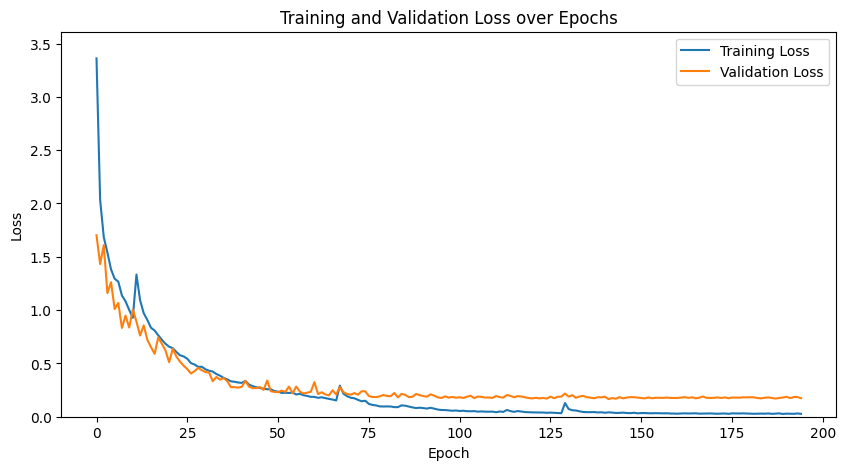

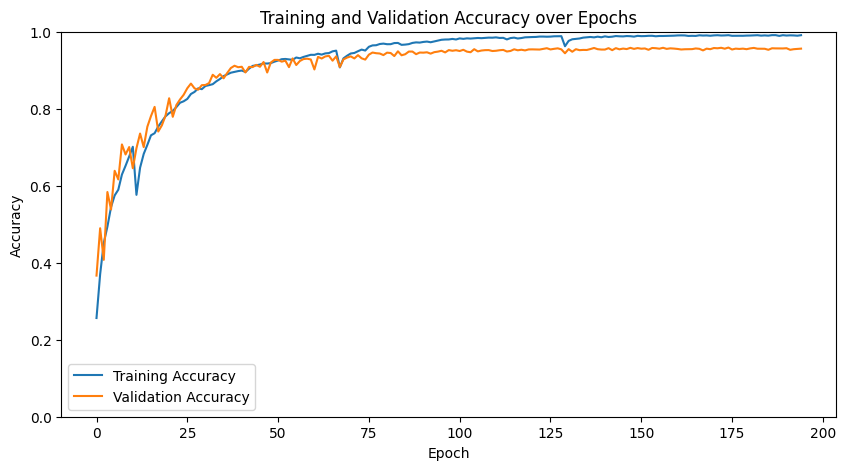

In [15]:
training_loss = history.history["loss"]
training_accuracy = history.history["accuracy"]
validation_loss = history.history["val_loss"]
validation_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(10, 5))
plt.ylim([0.0, max(max(training_loss), max(validation_loss)) + 0.25])
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.ylim([0.0, 1.0])
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
y_pred = []
y_true = []

for _ in range(128):
    X_batch, y_batch = next(iter(val_gen))
    y_pred.append(model.predict(X_batch, verbose=0))
    y_true.append(y_batch)

y_pred = np.concatenate(y_pred).argmax(axis=1)
y_true = np.concatenate(y_true).argmax(axis=1)

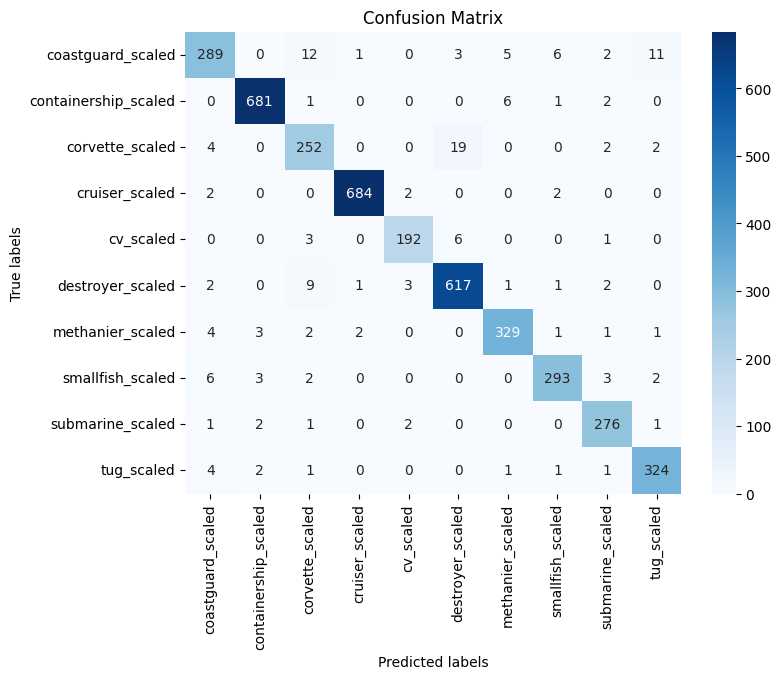

In [17]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cmat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cmat,
    xticklabels=_CLASS_NAMES,
    yticklabels=_CLASS_NAMES,
    annot=True,
    cmap="Blues",
    fmt="d",
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       329
           1       0.99      0.99      0.99       691
           2       0.89      0.90      0.90       279
           3       0.99      0.99      0.99       690
           4       0.96      0.95      0.96       202
           5       0.96      0.97      0.96       636
           6       0.96      0.96      0.96       343
           7       0.96      0.95      0.95       309
           8       0.95      0.98      0.96       283
           9       0.95      0.97      0.96       334

    accuracy                           0.96      4096
   macro avg       0.95      0.95      0.95      4096
weighted avg       0.96      0.96      0.96      4096



# Test


In [19]:
import numpy as np
import pandas as pd

In [20]:
X_test = np.load("test.npy", allow_pickle=True)
X_test = X_test.astype("float32") / 255
X_test = np.expand_dims(X_test, axis=-1)


def submission_get(model):
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category": res})
    df.to_csv("reco_nav.csv", index_label="ID")

In [21]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  20


In [22]:
submission_get(model)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step


In [23]:
%%bash
head reco_nav.csv

ID,Category
0,5
1,2
2,2
3,3
4,8
5,8
6,4
7,2
8,7


# Proof of Work

In [24]:
import hashlib


def compute_file_hash(file_path):
    hash_func = hashlib.new("sha256")
    with open(file_path, "rb") as f:
        while chunk := f.read(8192):
            hash_func.update(chunk)
    return hash_func.hexdigest()

In [25]:
compute_file_hash(_BEST_MODEL_PATH)

'dfb8412ecb571d19075f6916fd5eb584ee2c524761d3cf648ee414609471d0f2'